# New York City Taxi Trip Duration

In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## Data fields

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the - vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 12]

## 1. Обзор данных

In [2]:
train = pd.read_csv('train.zip', compression='zip')
test = pd.read_csv('test.zip', compression='zip')

In [3]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [4]:
train.sample(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
137474,id3300302,2,2016-03-20 09:07:34,2016-03-20 09:15:12,1,-73.960930,40.757370,-73.987503,40.738468,N,458
997173,id1763818,2,2016-01-07 08:45:16,2016-01-07 08:51:45,2,-73.928047,40.769741,-73.941971,40.754574,N,389
8843,id1147127,2,2016-04-06 08:33:51,2016-04-06 08:55:06,2,-73.977020,40.790218,-73.962196,40.772106,N,1275
1020608,id1418541,1,2016-04-25 02:44:14,2016-04-25 03:00:17,4,-73.961121,40.714603,-73.977135,40.747795,N,963
996745,id2625212,2,2016-03-19 23:35:04,2016-03-19 23:47:55,1,-73.983772,40.743801,-73.953300,40.766720,N,771
392469,id1473151,1,2016-05-15 22:26:31,2016-05-15 22:35:48,1,-74.000153,40.742821,-73.980782,40.756481,N,557
557228,id2036090,2,2016-02-05 22:00:39,2016-02-05 22:09:08,1,-74.001892,40.724461,-73.992126,40.723980,N,509
1313417,id3643189,1,2016-01-18 01:59:26,2016-01-18 02:01:20,1,-73.988472,40.731441,-73.989761,40.725739,N,114
1159831,id3950341,2,2016-01-04 09:17:23,2016-01-04 09:28:33,1,-73.995087,40.744869,-73.978340,40.757671,N,670
288817,id2282157,1,2016-05-16 00:35:43,2016-05-16 01:03:21,4,-73.782471,40.644539,-73.985115,40.761276,Y,1658


### Количество наблюдений с отсутствующими значениями

In [5]:
len(train[train.isnull().any(axis=1)])

0

### Преобразование данных

In [6]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

### Проверка согласованности данных: время поездки должно быть в интервале между временем посадки и высадки

In [7]:
delta_datetime = (train['dropoff_datetime'] - train['pickup_datetime']).dt.total_seconds()
(delta_datetime >= train['trip_duration']).values.all()

True

### Информация по тестовой выборке

In [8]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816,0.005487
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824,0.073870
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322,0.000000
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000,0.000000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543,0.000000
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852,0.000000
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597,1.000000


In [9]:
test.sample(10)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
423386,id2359207,2,2016-03-01 15:50:09,1,-73.972633,40.793144,-73.961121,40.805264,0
530224,id0141144,1,2016-01-31 02:14:06,2,-74.004936,40.741646,-73.993675,40.746784,0
131086,id1115863,1,2016-05-22 09:42:38,1,-73.977158,40.746342,-73.990265,40.751247,0
207075,id3479922,2,2016-05-01 08:51:41,1,-73.798729,40.645199,-74.044037,40.786449,0
297493,id3403208,2,2016-04-05 22:08:43,1,-73.988800,40.736771,-73.964104,40.756729,0
83572,id3892359,2,2016-06-05 19:25:29,1,-73.973503,40.689629,-73.958466,40.721981,0
74367,id0531879,1,2016-06-08 15:53:08,1,-73.982300,40.746037,-73.782822,40.648884,0
242178,id1968541,2,2016-04-21 06:59:46,1,-73.951218,40.785149,-73.977707,40.753502,0
487767,id3566140,1,2016-02-12 12:53:51,1,-73.979378,40.761787,-74.015884,40.706573,0
484633,id1098059,1,2016-02-13 09:07:47,1,-73.985207,40.734962,-73.986588,40.750046,0


## 2. Визуализация

### Гистограмма времени в пути в логарифмическом масштабе

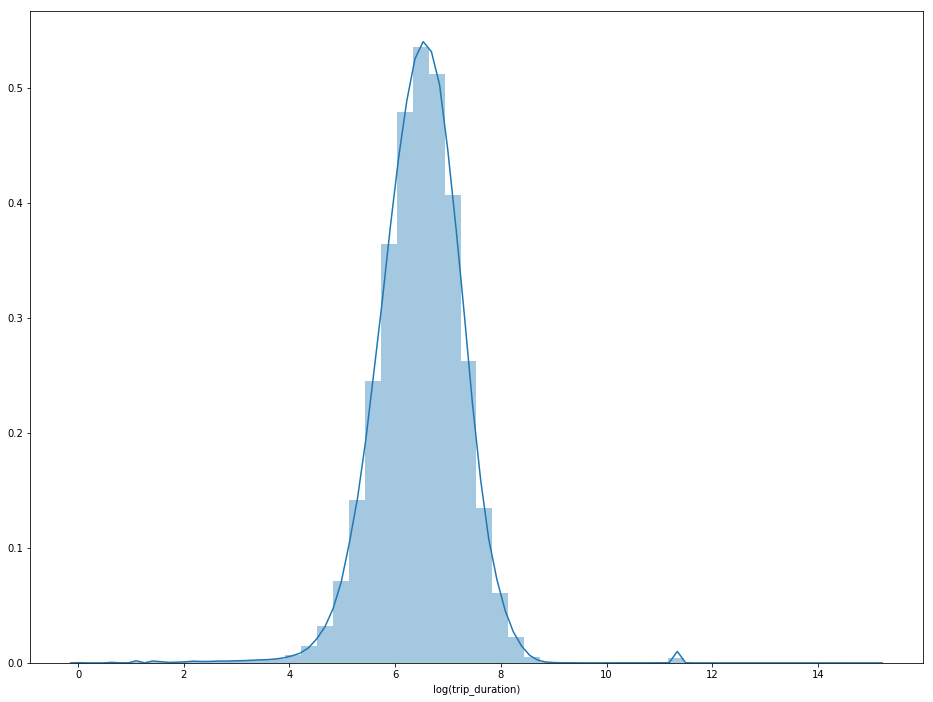

In [10]:
sns.distplot(np.log(train['trip_duration']), axlabel = 'log(trip_duration)')

### Доли вызовов для каждой компании

In [11]:
vendors = train['vendor_id'].unique()
total = train['store_and_fwd_flag'].count()

for vendor_id in vendors:
    count = train[train['vendor_id'] == vendor_id]['store_and_fwd_flag'].count()
    print('Vendor with id "{}": {}'.format(vendor_id, count/total))


Vendor with id "2": 0.5349502688798637
Vendor with id "1": 0.46504973112013626


### Карты посадок и высодок

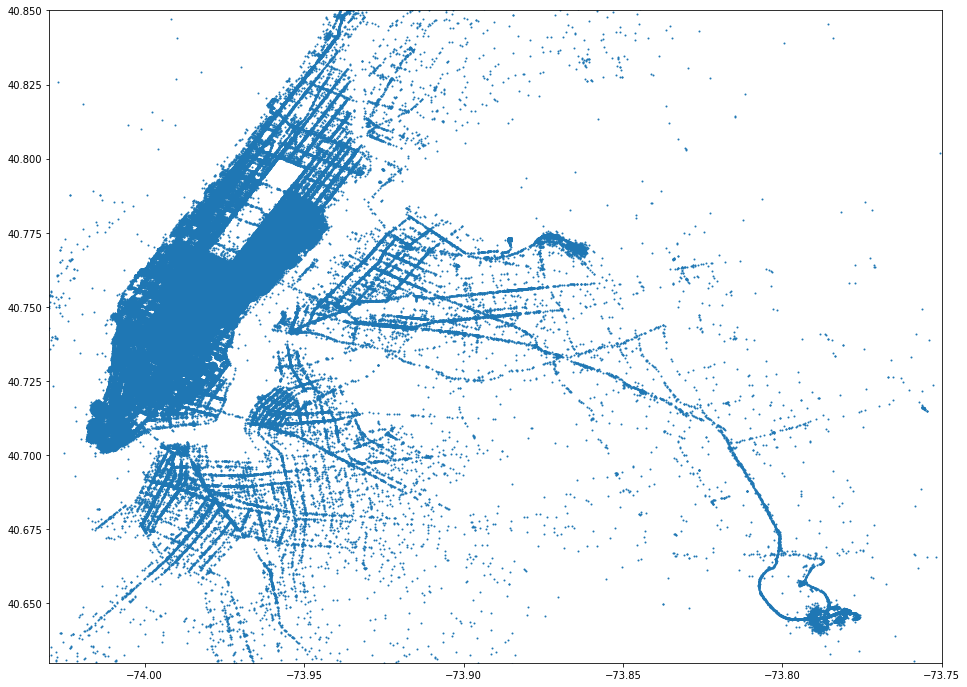

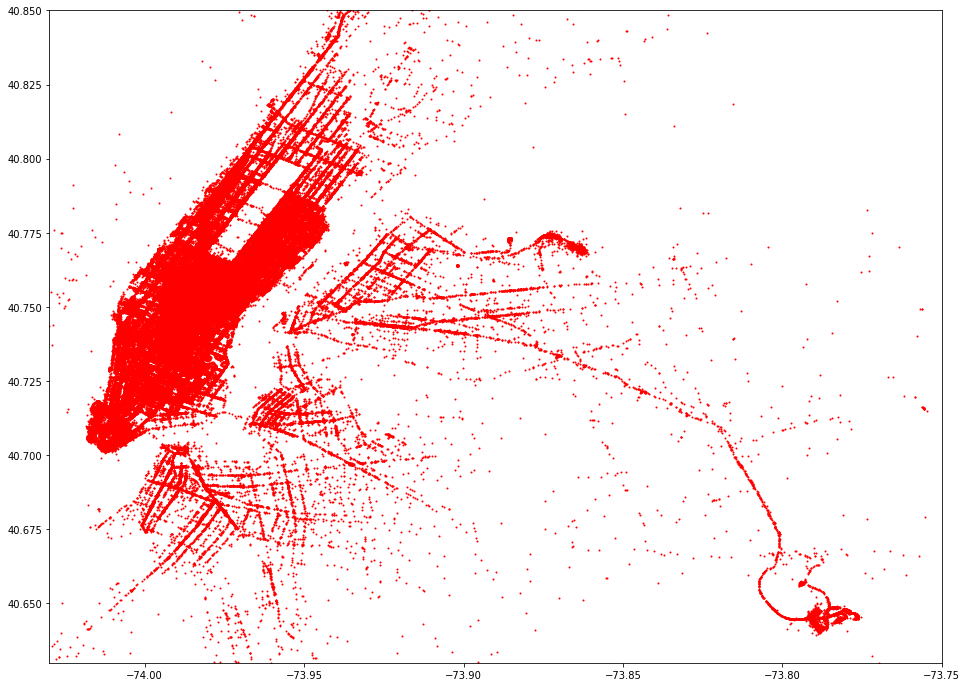

In [12]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.scatter(train['pickup_longitude'].values, train['pickup_latitude'].values, label='train', s=1)

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

plt.scatter(test['pickup_longitude'].values, test['pickup_latitude'].values, label='test', s=1, color='red')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

### Распределение количества посадок и количества высадок по месяцам

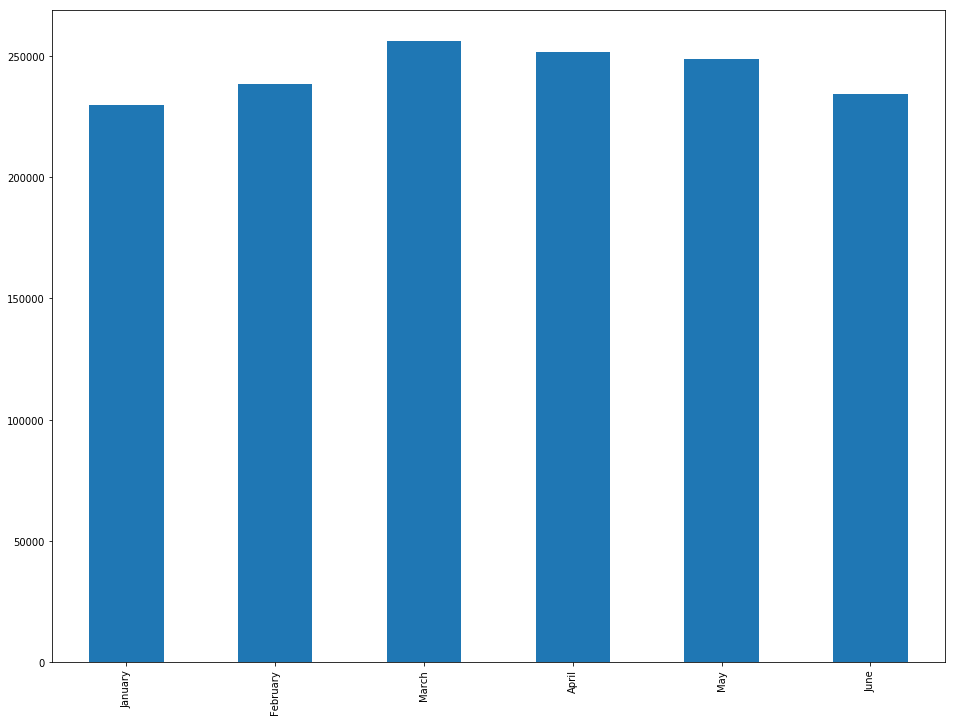

In [13]:
train_pickups_by_month = train.groupby(pd.TimeGrouper(key='pickup_datetime', freq='M')).size()
train_pickups_by_month.index = train_pickups_by_month.index.strftime('%B')
train_pickups_by_month.plot('bar')

### Распределение количества пассажиров в поездках

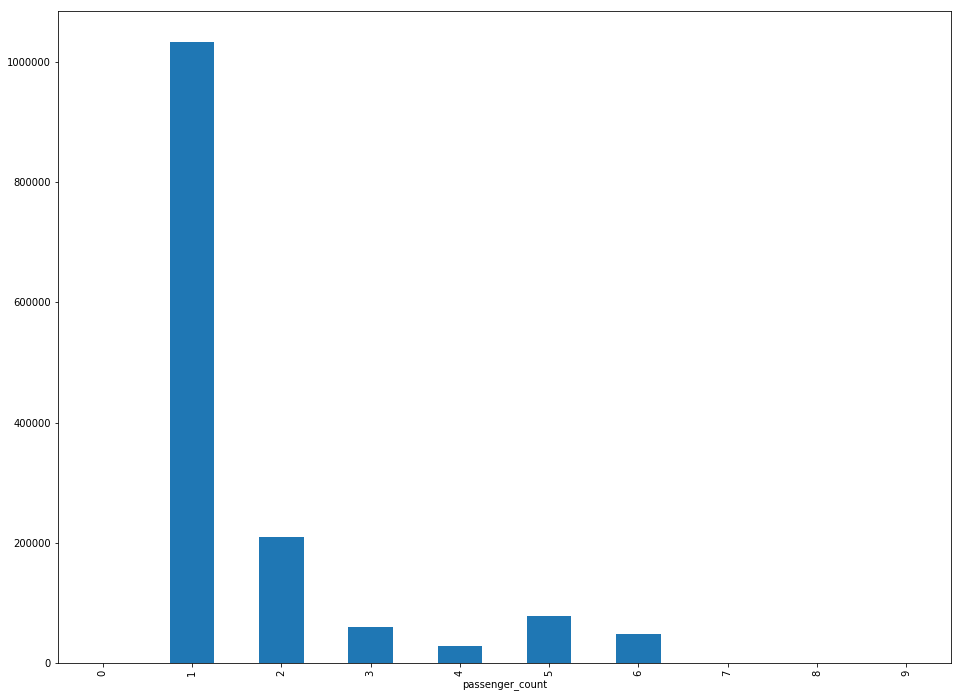

In [14]:
train.groupby('passenger_count').size().plot('bar')

### Распределение количества посадок в зависимости от дня недели (одна кривая для каждой из компаний)

In [15]:
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday

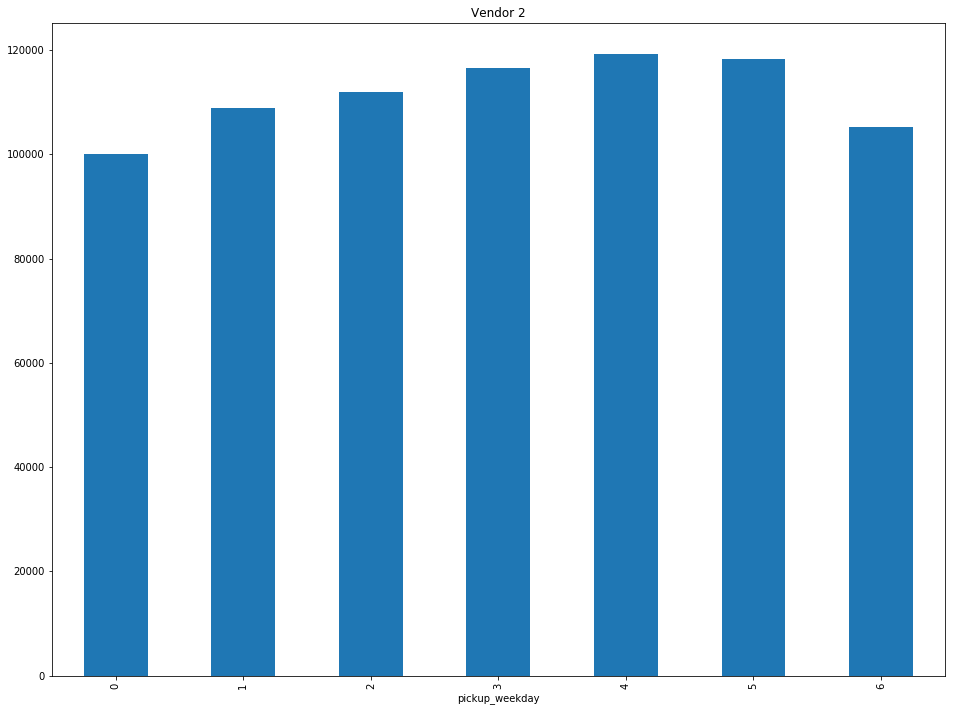

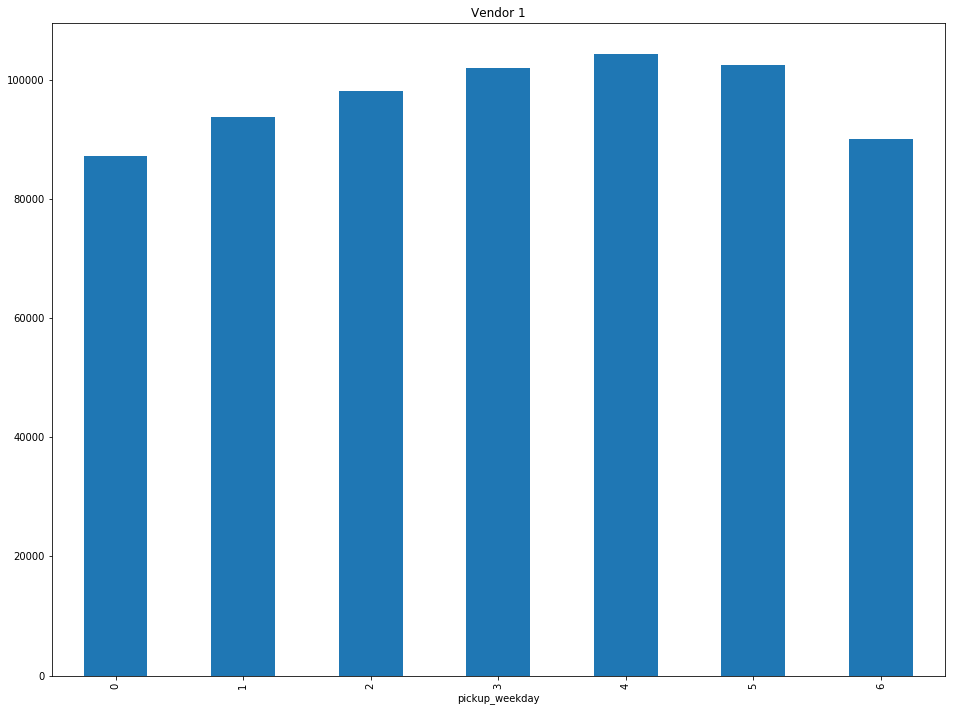

In [16]:
for vendor_id in vendors:
    vendor = train[train['vendor_id'] == vendor_id]
    vendor.groupby('pickup_weekday').size().plot(title='Vendor {}'.format(vendor_id), kind='bar')
    plt.show()

### Распределение количества посадок в зависимости от времени суток (одна кривая для каждой из компаний)

In [17]:
# 0 - night, 1 - day
train['pickup_day_time'] = np.where(train['pickup_datetime'].dt.hour <= 6, 0, 1)
test['pickup_day_time'] = np.where(test['pickup_datetime'].dt.hour <= 6, 0, 1)

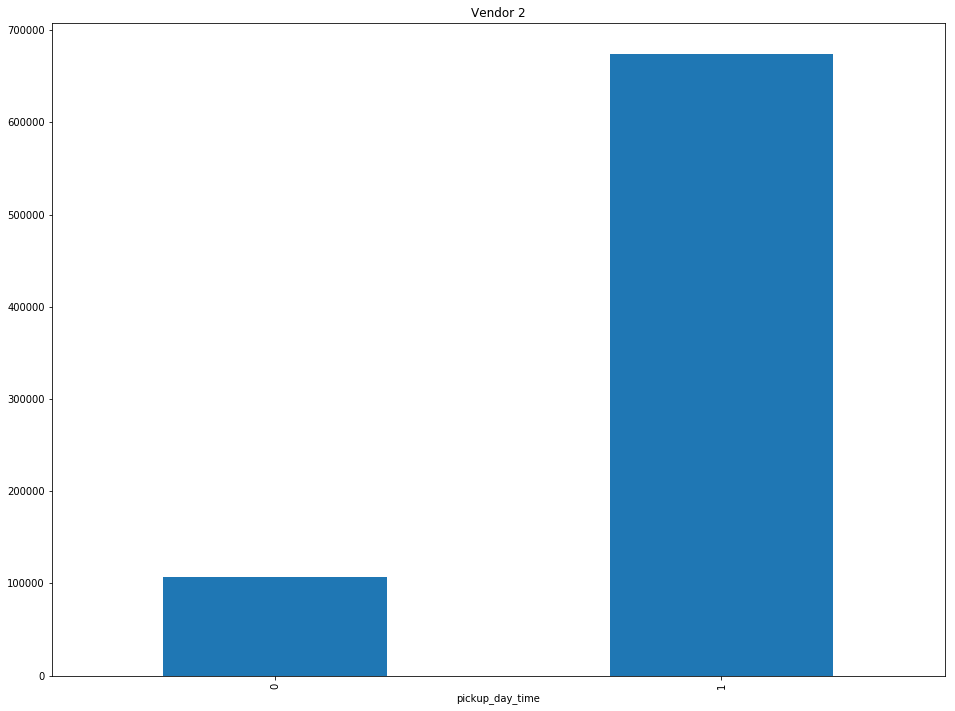

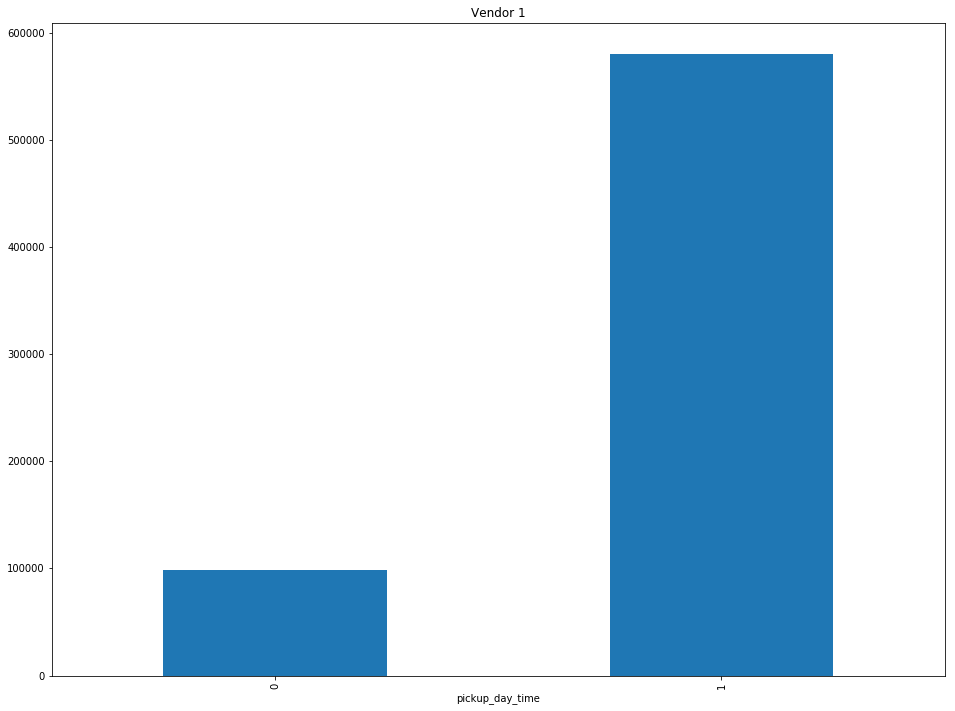

In [18]:
for vendor_id in vendors:
    vendor = train[train['vendor_id'] == vendor_id]
    vendor.groupby('pickup_day_time').size().plot(title='Vendor {}'.format(vendor_id), 
                                                  kind='bar')
    plt.show()

### Влияет ли вид компании на время поездки? (Не влияет)

In [19]:
train['vendor_id'].corr(train['trip_duration'])

0.020304177490054795

## Проектирование новых признаков

In [20]:
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute

test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute

In [21]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

### Дистанция поездки

In [22]:
train['distance'] = train[['pickup_longitude', 
                   'pickup_latitude', 
                   'dropoff_longitude', 
                   'dropoff_latitude']].apply(lambda x: haversine(*x), axis=1)

test['distance'] = test[['pickup_longitude', 
                         'pickup_latitude', 
                         'dropoff_longitude', 
                         'dropoff_latitude']].apply(lambda x: haversine(*x), axis=1)

### Средняя скорость поездки

In [23]:
train['avg_speed'] = (train['distance'] / (train['dropoff_datetime'] - train['pickup_datetime']).dt.total_seconds()) * 60 * 60

## Устранение выбросов

### Устранение наблюдений у которых подозрительная продолжительность поездки (больше чем 24 часа)

In [24]:
train.drop(train[train['trip_duration'] / 360 > 24].index, inplace=True)

### Устранение наблюдений с нулевой "дистанцией_поездки", если они по времени заняли больше минуты

In [25]:
train.drop(train[(train['distance'] == 0) & (train['trip_duration'] / 60 > 1)].index, inplace=True)

### Устранeние наблюдений с нереалистичной средней скоростью (>100км/ч)

In [26]:
train.drop(train[train['avg_speed'] > 100].index, inplace=True)

## Использование внешних источников данных (погода)

In [27]:
weather = pd.read_csv('weather-data-in-new-york-city-2016.zip', compression='zip', 
                      skiprows=1,
                      names=[
                          'date', 
                          'maximum_temperature', 
                          'minimum_temperature', 
                          'average_temperature', 
                          'precipitation', 
                          'snow_fall', 
                          'snow_depth'
                      ],
                      parse_dates=['date'])

In [28]:
weather.head()

,date,maximum_temperature,minimum_temperature,average_temperature,precipitation,snow_fall,snow_depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-02-01,40,32,36.0,0.00,0.0,0
2,2016-03-01,45,35,40.0,0.00,0.0,0
3,2016-04-01,36,14,25.0,0.00,0.0,0
4,2016-05-01,29,11,20.0,0.00,0.0,0


In [29]:
weather.replace('T', 0, inplace=True)

In [30]:
weather = weather.astype(dtype={
    'maximum_temperature': 'float64', 
    'minimum_temperature': 'float64', 
    'average_temperature': 'float64',
    'precipitation': 'float64',
    'snow_fall': 'float64',
    'snow_depth': 'float64'
})

In [31]:
train['date'] = train['pickup_datetime'].dt.date.astype('datetime64[ns]')
test['date'] = test['pickup_datetime'].dt.date.astype('datetime64[ns]')

### Добавить параметры погоды в обучающую и тестовую выборку

In [32]:
train = pd.merge(train,
                 weather,
                 on='date',
                 how='inner')

test = pd.merge(test,
                weather,
                on='date',
                how='inner')

## Обучение и предсказание

### Подготовка данных

In [33]:
train['pickup_datetime'] = pd.to_numeric(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_numeric(train['dropoff_datetime'])
train['date'] = pd.to_numeric(train['date'])

train = train.sample(10000)

In [34]:
X_train = train.drop(['id', 'date', 'vendor_id', 'dropoff_datetime', 'trip_duration', 'avg_speed'], axis=1).values
y_train = np.log(train['trip_duration'].values)

In [35]:
test['pickup_datetime'] = pd.to_numeric(test['pickup_datetime'])
test['date'] = pd.to_numeric(train['date'])
test['date'] = test['date'].fillna(test['date'].median())

In [36]:
X_test = test.drop(['id', 'date', 'vendor_id'], axis=1).values

### MLPRegressor

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

estimator = Pipeline([
    ('scaler', MinMaxScaler()),
#     ('pca', PCA(n_components=0.99, svd_solver='full')),
    ('mlp', MLPRegressor(learning_rate_init=0.0005, max_iter=1000))
])

param_grid = {
#     'pca__n_components': (0.90, 0.95, 0.99),
    'mlp__hidden_layer_sizes': [(500, 500)],
    'mlp__alpha': [(0.001)]
}

grid_search = GridSearchCV(estimator, param_grid, cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (500, 500)}


#### Predicting

In [42]:
prediction = np.exp(grid_search.predict(X_test))

In [43]:
test = pd.read_csv('test.zip', compression='zip')

submission = pd.DataFrame({
        "id": test['id'],
        "trip_duration": prediction.astype(int)
    })

submission.to_csv('./mlp_submission.csv', index=False)